<a href="https://colab.research.google.com/github/juanmadlg/K-armed-Bandit-Problem/blob/main/K_Armed_Testbed_with_Optimistic_Initial_Values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## k-armed Testbed with Optimistic Initial Values

*This is a evolution of the K-Armed Testbed already implemented [here](https://gist.github.com/juanmadlg/bc25bc44af651d2dde48b708c2af87d9)*.

This is an update of the previous version to allow the evaluation of including Optimistic Initial Values. That means to start with a value different from 0 for all the actions in Q(a). The optimal value for this Optimistic Initial Value could be the maximum possible Q(a) of all a in A.

**Note:** This Notebook has been created in Google Colab.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.

In [ ]:
!pip install jdc

In [ ]:
# Imports
import numpy as np
import jdc
from tqdm import tqdm
import matplotlib.pyplot as plt

## K-Arms Class

These are the elements included in the K-Arms Class
* **k**: The number of Arms
* **Q**: It stores the Function Values for each Arm. Vector of size (k, )
* **q_ini**: Initial value. Used for Optimistic inizialization
* **A**: It stores the number of 'executions' of the specific Arm. Vector of size (k, ). Initializated each time 'reset' is executed.
* **arms_mean**: Mean for the distribution of the Q* for each Arm
* **standard_deviation**: It is used in two cases: 
  * To generate the random distribution of the Q* for each Arm 
  * To generate the random value of an Arm when it is executed (using the on the Q* of the arm as a mean).
* **e**: Epsilon for action selection

In [ ]:
class k_armed:
  def __init__(self, configuration):
    '''
    Configuration is a dictionary that includes all diferente required settings
    '''
    self.Q = None
    self.N = None
    self.A = None
    self.k = configuration['k'] # Number of Arms
    self.e = configuration['e']
    self.q_ini = configuration['q_ini'] # Optimistic Inicial Value

    self.arms_mean = configuration['arms_mean']
    self.standard_deviation = configuration['std_dev'] # For Arms Distribution and Arms values

  def reset(self):
    '''
    Reset is executed at the begining of each episode. It sets to 0 Q and N
    and creates a new distribution of Q* for the k arms.
    '''
    self.Q = np.full((self.k, ), self.q_ini) # Initialize optimistic values
    self.N = np.zeros((self.k,))
    self.A = np.random.normal(loc=self.arms_mean, scale=self.standard_deviation, size=(self.k,))

### Episilon-greedy action selection

A simple method to balance exploration and exploitation



In [ ]:
%%add_to k_armed

def get_action(self):
  '''
  €-greedy action selection: exploration vs. exploitation
  '''
    
  if np.random.random_sample() <= self.e:
    return np.random.randint(self.k) # Exploration

  return np.argmax(self.Q) # Exploitation

### Bandit

Returns a random value in a normal distribution with Q*(arm) and the standard_deviation

In [ ]:
%%add_to k_armed

def bandit(self, a):
  '''
  Gets value of the selected arm based on a normal distribution with Q*(a) as the mean
  '''
  return np.random.normal(self.A[a], self.standard_deviation)

### k-armed Execution

For each step:
* Get the Action (Arm) (€-greedy action selection)
* Get the Value (Reward) for that Arm
* Increment the number of Steps
* Calculate the Value Function for the Arm: Qn+1 = Qn + (Rn - Qn) / n  

In [ ]:
%%add_to k_armed

def exec(self, steps):
  self.reset()

  rewards = []
  for i in range(steps):

    A = self.get_action()
    R = self.bandit(A)

    self.N[A] += 1
    self.Q[A] = self.Q[A] + (R - self.Q[A]) / self.N[A] # Update Value Function Q(a)

    rewards.append(R)

  return rewards

## Evaluate the Rewards

### Evaluate different epsilon values and optimal inizialization values

We cannot evaluate the diference only with an execution for each epsilon value. The curve is too noisy.

To evaluate the different values of epsilon we are going to execute N different runs an calculate the average for each step.

In [ ]:
def evaluate(configuration, test_values, steps, runs):
  rewards = []

  # For these three epsilon values
  for epsilon, q_ini in test_values:
    print(f'Execution {runs} runs with epsilon {epsilon} and q_ini {q_ini}')
    configuration['e'] = epsilon
    configuration['q_ini'] = q_ini

    e_k_armed = k_armed(configuration)
    epsilon_rewards = np.zeros((steps, ))

    # Lets execute son independent runs
    for _ in range(runs):
      epsilon_rewards = np.add(epsilon_rewards, e_k_armed.exec(steps))

    # Average for each step
    rewards.append(epsilon_rewards / runs)

  return rewards

In [ ]:
configuration = {
    'k': 10,
    'e': None,
    'q_ini': None,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 600
runs = 2000
optimal_initial_value = 3.0

rewards = evaluate(configuration, [[0.1, 0.0], [0.0, optimal_initial_value], [0.1, optimal_initial_value], [0.5, optimal_initial_value]], steps, runs)

Execution 2000 runs with epsilon 0.1 and q_ini 0.0
Execution 2000 runs with epsilon 0.0 and q_ini 3.0
Execution 2000 runs with epsilon 0.1 and q_ini 3.0
Execution 2000 runs with epsilon 0.5 and q_ini 3.0


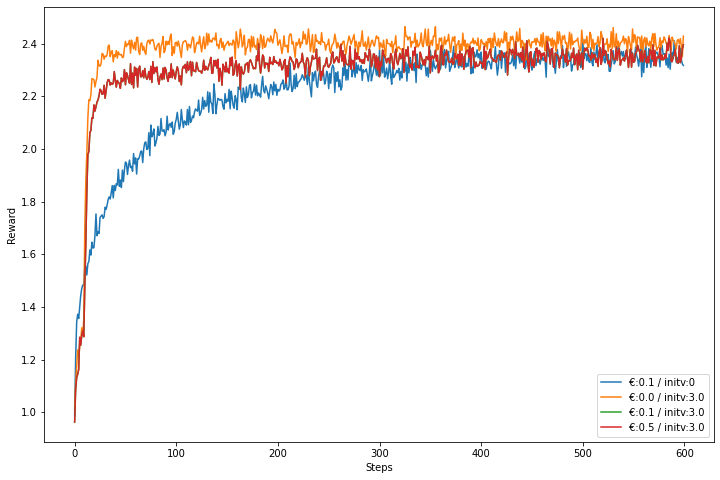

In [ ]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(steps)], rewards[0], label='€:0.1 / initv:0')
plt.plot([i for i in range(steps)], rewards[1], label='€:0.0 / initv:3.0')
plt.plot([i for i in range(steps)], rewards[2], label='€:0.1 / initv:3.0')
plt.plot([i for i in range(steps)], rewards[2], label='€:0.5 / initv:3.0')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

**Conclusions**

We can see the different performances for the different epsilon values and initial values:

|#|epsilon|initial value|performance|
|-|-------|-------------|-----------|
|A|    0.1|          0.0|Wrost      |   
|B|    0.0|          3.0|Best       |
|C|    0.1|          3.0|           |
|D|    0.5|          3.0|           |

* **Case A**: This is the configuration that was the best in the previous implementation of the K-Armed Testbed. The initial value is 0.
* **Case B**: The best performance is got without exploration via epsilon greedy (epsilon=0.0) and an optimal initial value (3.0). Action selection is greedy. The exploration is faster due to the initial value. The less explored actions are selected until they reveal little value. 
* **Case C**: It is interesting to see that apply epsilon greedy with initial values is not as good as the previous case. There is too much exploration initially.
* **Case D**: Same conclusion than previous one.

**Cons of using Optimistic Initial Values**

* Exploration is only done in the initial phases. So, this solution is not valid for non-stationary problems where the Q(a) could change along the time.
* It could be difficult to find the Optimal initial value if you don't have previous knowledge of the problem.